# 물류 유통량 예측(Distribution volume of logistics Analysis)

## 문제상황  

A물류업체는 상/하차 과정에서 물품 파손 등에 대한 고객 클레임 건수가 증가하고 있다. 물품의 특성마다 조심해야하는 부분이 다르기 때문에  
여간 힘든 일이 아니다. 따라서 A사는 특정 물품이 많이 배송되는 지역들을 구분하고 용도에 맞는 적절한 택배차량을 선정하여 배송을 운영하려고 한다.

## 문제 해결 프로세스  

1. 문제정의

- 상품 배송 고객 Claim건수 증가, 물품 파손 건수 증가

2. 기대효과

- 고객 Claim건수 감소, 물품 파손 건수 감소   

3. 해결방안

- 지역별 물품 배송량 분석을 통해 적정 차량 배차 및 직원 교육 

4. 성과측정

- 배송 운영 후 Claim건수 모니터링 

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('C:/Users/USER/Desktop/Practice Project - ML/물류 유통량 예측/물류 유통량 예측.csv', encoding='cp949')
df.head(10)

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3
5,5,5013000778073200,4159000114016400,농산물,6
6,6,5011000316024300,4827000369060200,수산,5
7,7,5013000740006400,4111700017039400,농산물,3
8,8,4136000209094100,5013000823053400,아우터,3
9,9,5011000315056100,4127100026035200,농산물,8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31684 entries, 0 to 31683
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         31684 non-null  int64 
 1   송하인_격자공간고유번호  31684 non-null  int64 
 2   수하인_격자공간고유번호  31684 non-null  int64 
 3   물품_카테고리       31684 non-null  object
 4   운송장_건수        31684 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.2+ MB


In [5]:
df.isnull().sum()

index           0
송하인_격자공간고유번호    0
수하인_격자공간고유번호    0
물품_카테고리         0
운송장_건수          0
dtype: int64

#### 변수 해석 3가지  

1. 결측치 존재 여부

- 전체 데이터에서 모든 변수에 결측치가 존재하지 않는다.

- 결측치의 개수는 전체 5% 미만이면 보통 제거한다.

- 결측치를 대체하는 경우, object형태는 최빈값으로 대체하고, int64, float64형태는 평균으로 대체하거나 KNN을 사용할 수 있다.

2. 데이터 타입 설명

- 종속변수는 int64형태, 독립변수는 int64형태, object형태로 구성되어 있다.

3. 컬럼 설명

- 송하인_격자공간고유번호 : 출발지 정보
- 수하인_격자공간고유번호 : 도착지 정보
- 물품_카테고리 : 물품_카테고리
- 운송장_건수 : 운송장_건수

In [6]:
df.describe()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,운송장_건수
count,31684.000000,3.168400e+04,3.168400e+04,31684.000000
mean,15841.500000,4.648814e+15,3.801369e+15,4.879308
std,9146.527301,8.341336e+14,1.314660e+15,6.756473
min,0.000000,1.111000e+15,1.111000e+15,3.000000
25%,7920.750000,4.713000e+15,2.826000e+15,3.000000
50%,15841.500000,5.011000e+15,4.159000e+15,3.000000
75%,23762.250000,5.013001e+15,5.011000e+15,5.000000
max,31683.000000,5.013001e+15,5.013001e+15,413.000000


우선 describe로 이상치를 판단하기 위해서는 mean, min, max 값을 확인하는 것이 좋다. mean과 min, mean과 max 값이 std에 비해 한참 차이가 난다면, 이상치가 있을 가능성이 높다. 이러한 이상치를 정확히 판단하기 위해서는 아래와 같이 boxplot으로 시각화하여 보는 것이 정확하다.

In [14]:
df_n = df.select_dtypes(exclude = 'object')
df_n

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,운송장_건수
0,0,5011000595017300,2871000192069300,3
1,1,4148000690043300,5011000264024400,3
2,2,5011000078068400,1120000007005400,3
3,3,4127100048006400,5011000587019400,7
4,4,5011000078068400,2823700010076300,3
...,...,...,...,...
31679,31679,4471000290087200,5011000213073200,3
31680,31680,1129000014045300,5011000319087100,4
31681,31681,1129000014045300,5011000263065200,6
31682,31682,4127300065073100,5011000264061200,7


In [15]:
outlier = pd.melt(df_n, var_name = '이상치 탐색 변수', value_name = '이상치 탐색 값')
outlier

,이상치 탐색 변수,이상치 탐색 값
0,index,0
1,index,1
2,index,2
3,index,3
4,index,4
...,...,...
126731,운송장_건수,3
126732,운송장_건수,4
126733,운송장_건수,6
126734,운송장_건수,7


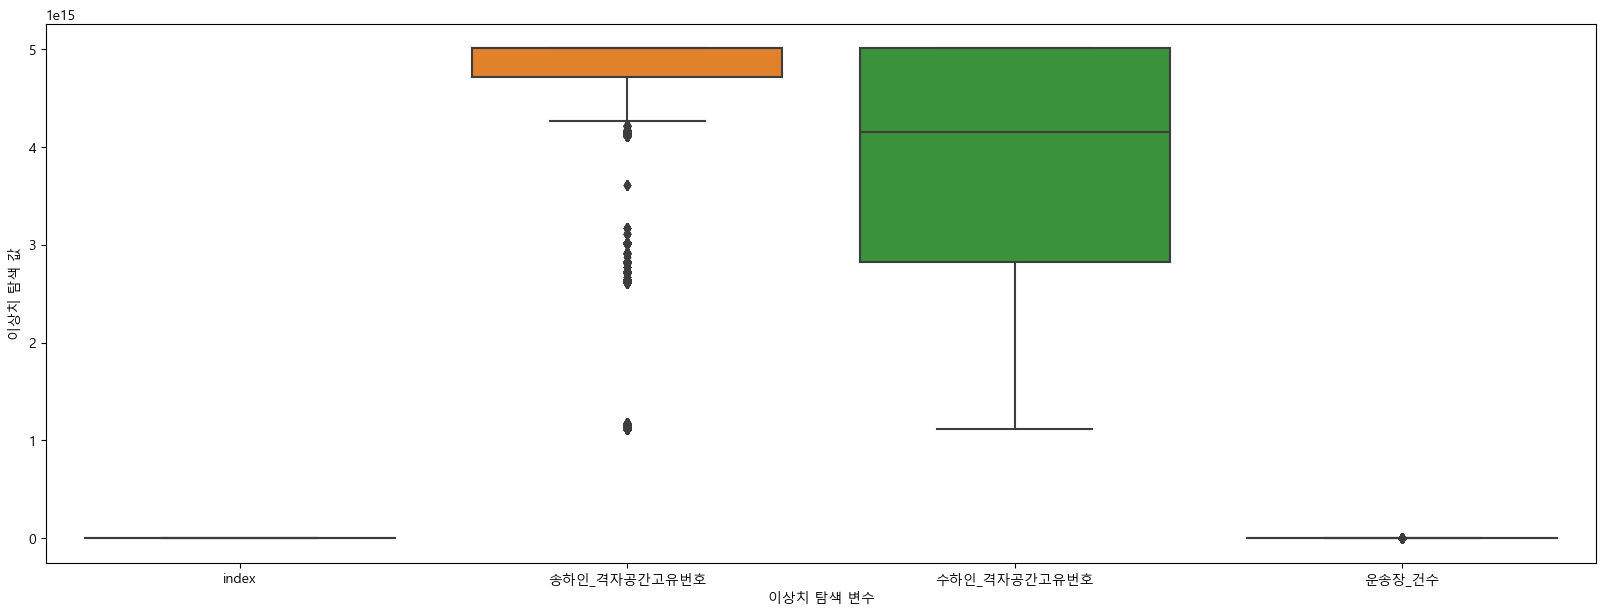

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc("font", family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize = (20,7))
sns.boxplot(x = '이상치 탐색 변수', y = '이상치 탐색 값', data = outlier)
plt.xticks(range(4), df_n.columns)
plt.show()

이상치를 탐색하기 위해서 수치형 변수들만 선택해서 boxplot으로 시각화하였다. 이상치의 값이 연속적으로 나타나면, 보통 의미있는 값일 확률이 높기 때문에 따로 제거하거나 대체하지 않고, 눈에 띄는 이상치가 있을 경우에는 보통 제거하거나 대체하는 경우가 많다(예를 들어, Age 변수가 999값이 있으면 제거하거나 대체하는 것이 옳다.)

### 배송 지역 탐색

In [17]:
df.columns = ['index', 'start', 'end', 'prod', 'cnt']
df.head(5)

,index,start,end,prod,cnt
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


편리한 사용을 위해 컬럼명을 영어로 재설정한다

In [18]:
df['start'].value_counts()

5011000078068400    3882
5013000610049100    1790
5013000731055200    1235
5011000137030100    1137
5013000821028200     731
                    ... 
4518000310022200       1
5011000428040200       1
1162000010086100       1
1153000017009300       1
5013000468023100       1
Name: start, Length: 4229, dtype: int64

배송 출발지 = 4,229개

In [19]:
df['end'].value_counts()

5013000635005300    35
5011000543041100    33
5011000314069300    33
5011000318044100    30
5011000544072300    30
                    ..
4812900019042100     1
4143000032094100     1
1165000020003400     1
5011000320081200     1
1156000004084300     1
Name: end, Length: 26875, dtype: int64

배송 도착지 = 26,875개  

출발지보다 도착지의 지역이 더 많다

In [22]:
all_list = list(df['start']) + list(df['end'])
unique_list = set(all_list)
print("총 지역(출발+배송) : ", len(unique_list))

총 지역(출발+배송) :  30455


### 물품 카테고리 탐색

In [24]:
df['prod'].value_counts()

농산물              20321
문화컨텐츠             1091
음료                1034
수산                 860
가공식품               846
                 ...  
스포츠잡화                4
기타출산/육아              4
선케어                  4
태블릿PC/노트북액세서리        4
유아가구                 4
Name: prod, Length: 100, dtype: int64

물품의 종류 = 총 100개의 물품 카테고리

In [25]:
df_cnt = df.groupby('prod', as_index=False)['cnt'].sum()
df_cnt = df_cnt.sort_values(by=['cnt'], ascending = False )
df_cnt.head(30)

,prod,cnt
27,농산물,87829
66,음료,5890
3,가공식품,5766
34,문화컨텐츠,5429
51,수산,4880
17,기타식품,4250
5,건강식품,3413
80,축산,3385
19,기타패션의류,3042
67,음반,2357


운송장 건수 기준으로 내림차순 정렬한 결과, 농산물이 가장 배송건수가 많다

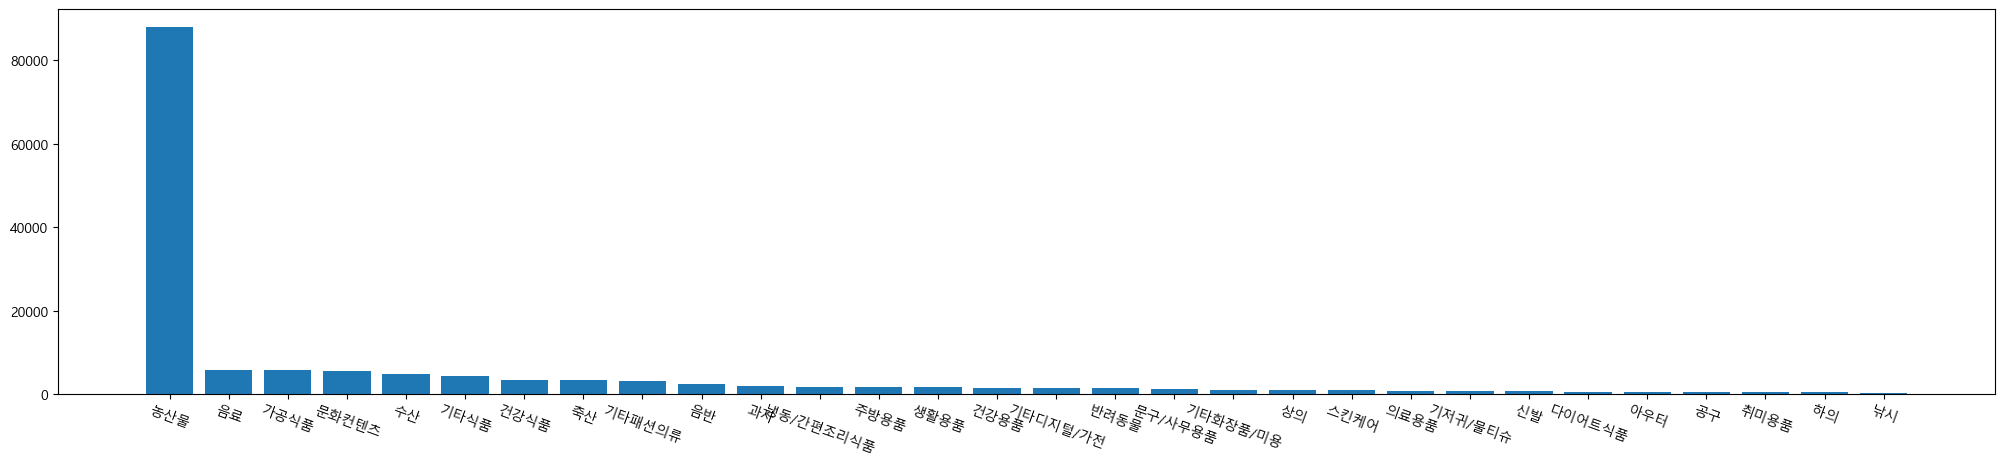

In [26]:
plt.bar(df_cnt['prod'][0:30], df_cnt['cnt'][0:30], label='cnt');
plt.xticks(rotation =-20);
plt.gcf().set_size_inches(25, 5);

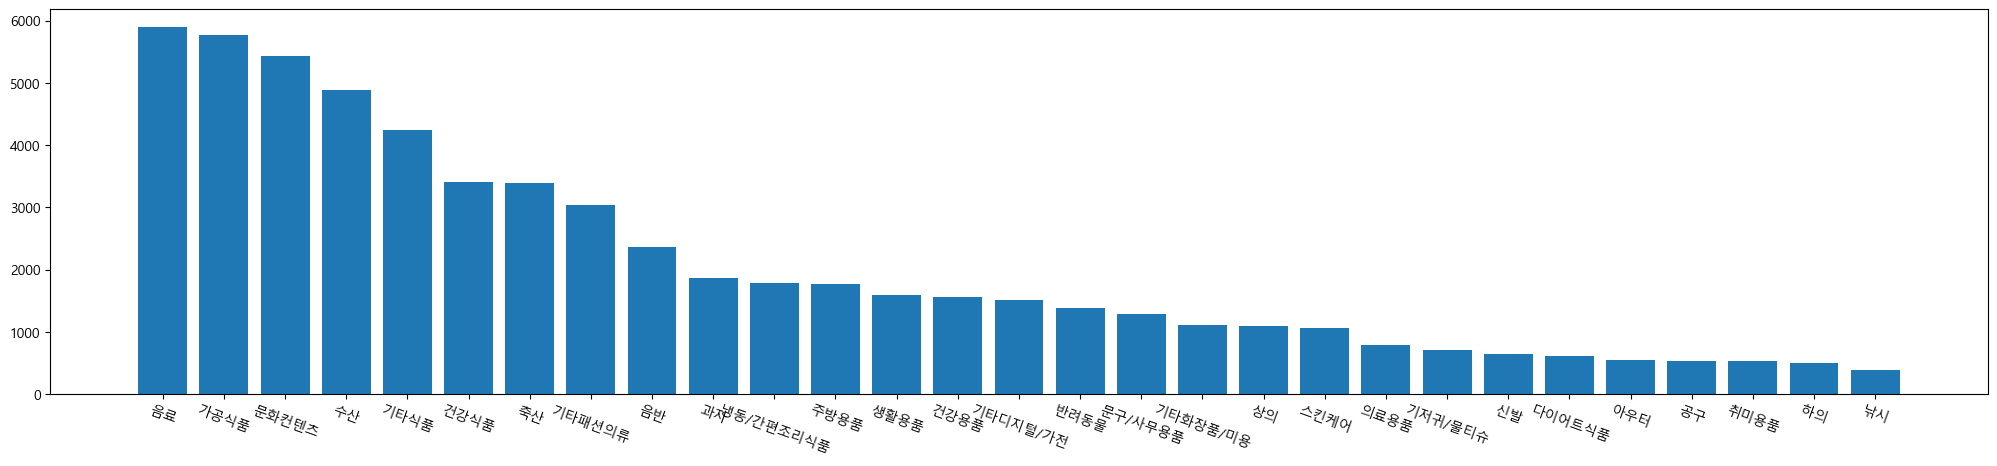

In [30]:
plt.bar(df_cnt['prod'][1:30], df_cnt['cnt'][1:30], label='cnt');
plt.xticks(rotation =-20);
plt.gcf().set_size_inches(25, 5);

농산물 건수가 다른 물품의 건수 비교 분석을 어렵게 하기 때문에 제거하고 다시 시각화한다

## 지역별 유통량 탐색

In [31]:
df['start'].value_counts()

5011000078068400    3882
5013000610049100    1790
5013000731055200    1235
5011000137030100    1137
5013000821028200     731
                    ... 
4518000310022200       1
5011000428040200       1
1162000010086100       1
1153000017009300       1
5013000468023100       1
Name: start, Length: 4229, dtype: int64

가장 많이 배송이 출발되는 지역 = 5011000078068400    

In [32]:
df['start'].value_counts().head(500).sum() / df['start'].value_counts().sum()

0.7936182300214619

출발지 기준 상위 500개의 장소에서 전체 배송건수에 80%이상을 조달함을 확인할 수 있다

In [33]:
df['end'].value_counts()

5013000635005300    35
5011000543041100    33
5011000314069300    33
5011000318044100    30
5011000544072300    30
                    ..
4812900019042100     1
4143000032094100     1
1165000020003400     1
5011000320081200     1
1156000004084300     1
Name: end, Length: 26875, dtype: int64

가장 많이 배송이 도착되는 지역 = 5013000635005300    

In [34]:
df['end'].value_counts().head(20500).sum() / df['end'].value_counts().sum()

0.7987943441484661

도착지 기준 상위 약 20,000개의 장소에서 전체 배송건수에 80%이상을 조달함을 확인할 수 있다

In [35]:
df_start_end = pd.DataFrame({'start' : df['start'].value_counts(), 'end': df['end'].value_counts()})
df_start_end.fillna(0, inplace = True)
df_start_end['total'] = df_start_end['start'] + df_start_end['end']
df_start_end.head(5)

,start,end,total
1111000004097200,0.0,1.0,1.0
1111000005062300,0.0,1.0,1.0
1111000005067400,0.0,1.0,1.0
1111000007059100,0.0,1.0,1.0
1111000007071100,0.0,1.0,1.0


In [36]:
df_start_end.sort_values(by=['total'], ascending = False).head(10)

,start,end,total
5011000078068400,3882.0,14.0,3896.0
5013000610049100,1790.0,0.0,1790.0
5013000731055200,1235.0,0.0,1235.0
5011000137030100,1137.0,2.0,1139.0
5013000821028200,731.0,0.0,731.0
4148000690015300,582.0,0.0,582.0
5013000777063100,475.0,0.0,475.0
5011000595017300,462.0,1.0,463.0
5011000213090100,454.0,3.0,457.0
5011000685067100,453.0,0.0,453.0


출발 및 도착 건수가 가장 많은 지역 = 5011000078068400

In [39]:
df_route = df.groupby(['start', 'end'], as_index=False)['prod'].count()
df_route.columns = ['start', 'end', 'prod']
df_route = df_route.sort_values(by=['prod'], ascending = False)
df_route.head(10)

,start,end,prod
3684,4141000031030100,5013000635005300,7
6712,4211000650079200,5011000437052400,7
735,1154500001021400,5011000214025100,5
3664,4141000031030100,5011000596012200,5
6962,4374500066090200,5011000427079100,5
2814,4128500028049400,5011000373021200,4
14369,5011000228004400,4117300017043200,4
3536,4141000031030100,5011000318044100,4
6952,4374000244008400,5011000373055300,4
3269,4137000019060200,5011000366024400,4


물품경로를 분석한 결과, 자주 배송되는 특정 경로 배송이 없다. 이렇게 되면 경로 기준으로 배차를 하는 방법은 사용불가능하다

In [40]:
df[(df['start']==4141000031030100) & (df['end']==5013000635005300)]

,index,start,end,prod,cnt
4810,4810,4141000031030100,5013000635005300,주방용품,7
5657,5657,4141000031030100,5013000635005300,이미용가전,4
14325,14325,4141000031030100,5013000635005300,스킨케어,7
17413,17413,4141000031030100,5013000635005300,생활가전,3
19976,19976,4141000031030100,5013000635005300,음료,3
20177,20177,4141000031030100,5013000635005300,베이스메이크업,5
22653,22653,4141000031030100,5013000635005300,상의,3


가장 많이 배송되는 지역의 물품이 다양하기 때문에 카테고리화도 쉽지 않아보인다

In [41]:
 pd.DataFrame(df[df['start']==4141000031030100].groupby('prod')['cnt'].sum().sort_values(ascending=False)).reset_index().head(1)

,prod,cnt
0,건강용품,468


출발 지역에서 가장 많이 배송되는 물품을 대표 물품으로 정의해본다

In [42]:
list_of_df = [] 

for i in list(df['start'].unique()) :
    loop_df = pd.DataFrame(df[df['start']==i].groupby('prod')['cnt'].sum().sort_values(ascending=False)).reset_index().head(1)
    loop_df['id'] = i
    list_of_df.append(loop_df)

df_accum_start = pd.concat(list_of_df) 

In [43]:
df_accum_start

,prod,cnt,id
0,음반,1652,5011000595017300
0,문화컨텐츠,383,4148000690043300
0,농산물,14380,5011000078068400
0,기타식품,96,4127100048006400
0,농산물,492,5013000778073200
...,...,...,...
0,기타패션잡화,9,4113300019005400
0,침구세트,4,4873000294001400
0,기타패션잡화,105,2638000008087200
0,스마트디바이스액세서리,3,1120000013030100


모든 출발 배송 지역에 대해서 상위 조건을 수행하기위한 for문을 작성한다 

In [44]:
df_prod_sum = pd.DataFrame(df.groupby('prod', as_index = False)['cnt'].sum())
df_prod_sum.columns = ['prod', 'total']
df_prod_sum.head(5)

,prod,total
0,DIY자재/용품,150
1,PC,200
2,PC주변기기,30
3,가공식품,5766
4,가방,26


물품별 전체 배송량 데이터를 생성한다

In [45]:
df_merge = pd.merge(df_accum_start, df_prod_sum, how='left', on='prod')
df_merge = df_merge[['id', 'prod', 'cnt', 'total']]
df_merge.head(5)

,id,prod,cnt,total
0,5011000595017300,음반,1652,2357
1,4148000690043300,문화컨텐츠,383,5429
2,5011000078068400,농산물,14380,87829
3,4127100048006400,기타식품,96,4250
4,5013000778073200,농산물,492,87829


In [46]:
df_merge['ratio'] = df_merge['cnt'] / df_merge['total']
df_merge.head(5)

,id,prod,cnt,total,ratio
0,5011000595017300,음반,1652,2357,0.700891
1,4148000690043300,문화컨텐츠,383,5429,0.070547
2,5011000078068400,농산물,14380,87829,0.163727
3,4127100048006400,기타식품,96,4250,0.022588
4,5013000778073200,농산물,492,87829,0.005602


전체 물품 배송량중 몇 퍼센트를 싣고 떠나는지 분석을 통해 차량 배차가 가능해진다

In [47]:
df_merge[df_merge['ratio'] > 0.50]

,id,prod,cnt,total,ratio
0,5011000595017300,음반,1652,2357,0.700891
57,4148000427007400,출산/유아동의류,23,30,0.766667
70,4148000690015300,문화컨텐츠,3064,5429,0.564376
96,1117000009037100,기타디지털/가전,837,1505,0.556146
359,4127300022051100,위생/건강용품,135,249,0.542169
457,5011000320025200,네일케어,35,69,0.507246
584,4873000228047300,낚시,316,386,0.818653
596,4150000196034300,다이어트식품,419,619,0.676898
1109,4117300018005400,기타패션의류,1605,3042,0.527613
1129,4413300143027400,신발,392,637,0.615385


전체 물품 중 적어도 50% 이상을 출발시키는 곳에 특정 배차를 할 수 있을 것이다

## ML 활용 유통량 예측

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

X=df.drop(['index', 'cnt'], axis=1)
Y=df['cnt']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=1239)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(19010, 3)
(19010,)
(12674, 3)
(12674,)


In [49]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(list(x_train['prod'].values) + list(x_test['prod'].values))
x_train['prod'] = le.transform(x_train['prod'])
x_test['prod'] = le.transform(x_test['prod'])

범주형 변수는 One-hot-encoding 또는 Label-encoding을 통해 숫자형 변수로 변경해야한다. One-hot-encoding은 차원이 많은 변수에는 적절하지 않고, Label-encoding은 차원이 많은 변수에 유용하기 때문에 Label-encoding을 진행한다

In [50]:
x_test['prod'].head(5)

17822    27
2269     51
37       27
24369    27
17187    27
Name: prod, dtype: int32

In [51]:
rfr = RandomForestRegressor(n_estimators=300, max_depth=8)
rfr.fit(x_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=300)

In [52]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
y_pred_train = rfr.predict(x_train)
y_pred_test = rfr.predict(x_test)


mae_train = mean_absolute_error(y_train, y_pred_train)
print('mae_train(mae): ', mae_train)
r2_train = r2_score(y_train, y_pred_train)
print('r2_score(r2): ', r2_train)
print('')
mae_test = mean_absolute_error(y_test, y_pred_test)
print('mae_test(mae): ', mae_test)
r2_test = r2_score(y_test, y_pred_test)
print('r2_score(r2): ', r2_test)

mae_train(mae):  2.198746305310656
r2_score(r2):  0.301436076579368

mae_test(mae):  2.3021036002495356
r2_score(r2):  0.22272790109313056


실제값과 예측값이 약 2.3정도 차이가 나고, 모델 설명력은 약 22%로 좋은 모델은 아니다

In [53]:
pd.options.display.float_format = '{:.5f}'.format
result = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred_test})
result['diff'] = result['Real Values'] - result['Predicted Values']
result.head(10)

,Real Values,Predicted Values,diff
17822,3,3.94421,-0.94421
2269,10,5.48819,4.51181
37,3,3.63750,-0.63750
24369,12,4.22152,7.77848
17187,3,4.25489,-1.25489
23981,3,5.11222,-2.11222
24832,10,3.90298,6.09702
11358,3,5.42713,-2.42713
12473,4,9.61354,-5.61354
19441,3,4.54785,-1.54785


In [54]:
result[result['diff']>20]

,Real Values,Predicted Values,diff
23314,109,7.76870,101.23130
22050,68,5.53637,62.46363
9417,30,9.27182,20.72818
8971,32,5.97624,26.02376
30697,29,5.11056,23.88944
...,...,...,...
8658,32,4.24175,27.75825
8366,27,5.04615,21.95385
11596,33,6.23307,26.76693
24382,44,6.66642,37.33358


성능이 좋지 않을 때는 해당 지역에 평균 배송량을 사용하는 것이 좋은 판단일 수 있다

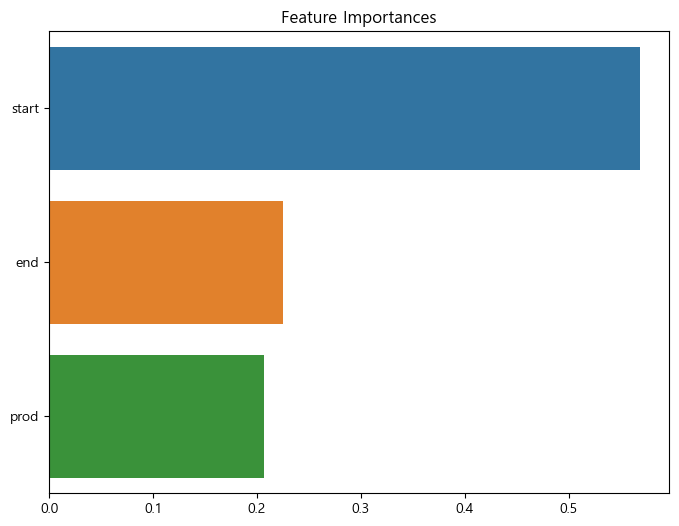

In [56]:
ftr_importances_values = rfr.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

Feature IMP 분석을 통해 중요변수를 파악한다. 위의 상위 변수들을 살펴보면, start(출발지)가 물류 유통량을 예측하는데 가장 중요한 변수임을 확인할 수 있다. 따라서 start(출발지)를 주의 깊게 살펴가면서 예측을 진행하는 것이 좋은 판단이다

해당 데이터는 모든 변수가 중요성을 띄고 있으므로 하위 변수들을 제거하고 다시 모델링하는 것은 좋지않다

성과측정은 기본 베이스 코드(위의 전체 코드)를 가지고 익월 데이터를 추가 업로드해서 성과비교가 필요하다. 예를 들어, 위의 데이터로 예측한 물류 유통량을 기반으로 배송 운영 후 Claim건수를 모니터링하여 비교하는 것이다